# Create validation for 2nd lvl model

In [1]:
import gc
import logging
import pickle
from typing import Tuple, Dict, List, Any, Set
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import implicit
from scipy.sparse.linalg import norm
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import memory_profiler
from tqdm import tqdm


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-poster')


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

%matplotlib inline
%load_ext memory_profiler

gc.enable()

In [2]:
from metrics import mapk, mapk_drop_empty_actual
from utils_validation import (
    concat_items,
    get_dates,
    get_sub_df,
    get_sub_df_personal_cold
)
from utils_validation_2lvl import (
    get_dates_2lvl,
    get_target,
    get_target_df
)
from utils_features_2lvl import (
    build_candidates,
    build_interaction_features,
    get_features_2lvl
)
from utils_frequent_pairs import (
    get_frequent_pairs,
    collect_freq_items,
    concat_pred_freq_items
)
from utils_heuristics import (
    popular_time_decay_predict,
    personal_time_decay_predict,
    gender_age_personal_cold_start_predict
)

from utils_models import (
    get_user_item_matrix,
    build_lookup_array
)

from utils_implicit_knn import (
    batch_array_sort,
    implicit_fit_predict
)

from utils_lightgbm import LightGBMRecommender

## Full Validation 2lvl

In [3]:
%%time
dir_path = '../input_data/processed_data/'
file_name = 'trans_clean_all.feather'

trans = pd.read_feather(dir_path + file_name)
trans.head()

CPU times: user 514 ms, sys: 569 ms, total: 1.08 s
Wall time: 292 ms


,t_dat,customer_id,article_id,price,sales_channel_id,cnt_articles
0,2018-09-20,2,541518023,304915,2,1
1,2018-09-20,2,663713001,508305,2,1
2,2018-09-20,7,505221001,203220,2,1
3,2018-09-20,7,505221004,152372,2,1
4,2018-09-20,7,685687001,169322,2,1


In [4]:
customers_data = pd.read_feather('../input_data/processed_data/customers_clean2.feather')
customers_data_feat = [
    'customer_id',
    #'FN',
    #'Active',
    'age',
    'postal_code',
    'gender_calc'
]
customers_data = customers_data[customers_data_feat]
def age_bin_util(x):
    if x < 25:
        return 18
    if 25 <= x < 35:
        return 25
    if 35 <= x < 45:
        return 35
    if 45 <= x < 55:
        return 45
    if x >= 55:
        return 55

customers_data['age_bin'] = customers_data['age'].apply(lambda x: age_bin_util(x))
customers_data.head()

,customer_id,age,postal_code,gender_calc,age_bin
0,0,49,0,1,45
1,1,25,1,1,25
2,2,24,2,1,18
3,3,54,3,0,45
4,4,52,4,1,45


In [5]:
article_cat_features = [
    'article_id',
    'product_code',
    'product_type_no',
    'graphical_appearance_no',
    'colour_group_code',
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_group_no',
    'section_no',
    'garment_group_no'
]

articles_data = pd.read_feather('../input_data/processed_data/articles_clean.feather')
# drop text features
articles_data = articles_data[article_cat_features]
articles_data.head()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
0,108775015,108775,253,1010016,9,4,5,1676,1,16,1002
1,108775044,108775,253,1010016,10,3,9,1676,1,16,1002
2,108775051,108775,253,1010017,11,1,9,1676,1,16,1002
3,110065001,110065,306,1010016,9,4,5,1339,1,61,1017
4,110065002,110065,306,1010016,10,3,9,1339,1,61,1017


In [6]:
SUB_PATH = '../input_data/processed_data/sub_user_ind.feather'

RANDOM_SEED = 7
NUM_THREADS = 8
NUM_TREES = 150

model_params = {
    "model_type_1lvl": "tfidf",
    "params_1lvl": {
        "num_candidates_1lvl": 100,
        "similarity_type": "u2u",
        "user_cnt_unq_items": 0,
        "item_cnt_unq_users": 0,
        #"user_item_values": "item_weight",
        "user_item_values": "price_weight",
        "use_item_rank": True,
        "params": {
            "K": 1000,
            "num_threads": 8
        },
    },
    "model_type_2lvl": "lightgbm",
    "params_2lvl": {
        "num_trees": NUM_TREES,
        "early_stopping_rounds": 50,
        "verbose_eval": 10,
        "params": {
            "boosting": "gbdt",
            "objective": "binary",
            "metric": ["auc"],
            "seed": RANDOM_SEED,
            "learning_rate": 0.01,
            "num_leaves": 50,
            "min_data_in_leaf": 300,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.6,
            "bagging_freq": 10,
            "lambda_l2": 0.1,
            "lambda_l1": 0.1,
            "num_threads": NUM_THREADS,
            "verbosity": 2,
            "histogram_pool_size": 16384,
            "max_bin": 255,
            "save_binary": True,
            "feature_pre_filter": True
        }
    }
}

In [7]:
%%time
# %%memit
NUM_FOLDS = 4
NUM_DAYS_FEATURES = 30 # 734 days in trans
NUM_DAYS_TARGET = 7
PERSONAL_GROUPBY = 'price_weight'

CUTOFF = 12

TARGET_VALID_START_DAY = '2020-08-26'
target_valid_start_date = datetime.strptime(TARGET_VALID_START_DAY, '%Y-%m-%d')
# get init dates
target_valid_start_date, target_valid_end_date, \
        feat_valid_start_date, feat_valid_end_date, \
        target_train_start_date, target_train_end_date, \
        feat_train_start_date, feat_train_end_date = get_dates_2lvl(
    target_valid_start_date,
    NUM_DAYS_TARGET,
    NUM_DAYS_FEATURES
)
mapk_dea_arr = []


for fold_num in range(NUM_FOLDS):
    logging.info('FOLD %s STARTED', fold_num + 1)
    # valid dates
    logging.info('target_valid_start_date = %s', target_valid_start_date.date())
    logging.info('target_valid_end_date = %s', target_valid_end_date.date())
    logging.info('feat_valid_start_date = %s', feat_valid_start_date.date())
    logging.info('feat_valid_end_date = %s', feat_valid_end_date.date())
    # train dates
    logging.info('target_train_start_date = %s', target_train_start_date.date())
    logging.info('target_train_end_date = %s', target_train_end_date.date())
    logging.info('feat_train_start_date = %s', feat_train_start_date.date())
    logging.info('feat_train_end_date = %s', feat_train_end_date.date())
    
    # load valid and train target
    target_valid = get_target(trans, target_valid_start_date, target_valid_end_date)
    logging.info('len(target_valid) = %s', len(target_valid))
    #target_train = get_target(trans, target_train_start_date, target_train_end_date)
    #logging.info('len(target_train) = %s', len(target_train))
    # get popular preidictions - time weighted items
    popular_articles = popular_time_decay_predict(trans, 
                                                  feat_valid_start_date, 
                                                  feat_valid_end_date, 
                                                  CUTOFF,
                                                  PERSONAL_GROUPBY)
    logging.info('len(popular_articles) = %s', len(popular_articles))
    
    preds_personal_cold = gender_age_personal_cold_start_predict(
        trans,
        feat_valid_start_date, 
        feat_valid_end_date,
        customers_data,
        articles_data,
        popular_articles,
        CUTOFF
    )
    logging.info('preds_personal_cold.shape = %s', preds_personal_cold.shape)
    
    # load train features
    features_train = get_features_2lvl(
        trans,
        feat_train_start_date, 
        feat_train_end_date,
        target_train_start_date, 
        target_train_end_date,
        model_params,
        customers_data.drop(['age_bin'], axis=1),
        articles_data,
    )
    # load valid features
    features_valid = get_features_2lvl(
        trans,
        feat_valid_start_date, 
        feat_valid_end_date,
        None,
        None,
        #target_valid_start_date, 
        #target_valid_end_date,
        model_params,
        customers_data.drop(['age_bin'], axis=1),
        articles_data,
    )
    # define and train 2lvl model
    recommender = LightGBMRecommender(
        num_trees=model_params['params_2lvl']['num_trees'],
        early_stopping_rounds=model_params['params_2lvl']['early_stopping_rounds'],
        verbose_eval=model_params['params_2lvl']['verbose_eval'],
        **model_params['params_2lvl']['params']
    )
    #recommender.fit(features_train, features_valid)
    recommender.fit(features_train)
    logging.info('Model %s fitted', model_params['model_type_2lvl'])
    
    # predictions calculation
    predictions_valid = recommender.predict(
        features_valid,
        num_candidates=CUTOFF,
        return_plain_df=False
    )
    logging.info('predictions_valid.shape = %s', predictions_valid.shape)
    
    #sub_df = get_sub_df(SUB_PATH, target_valid, predictions_valid, popular_articles, CUTOFF)
    sub_df = get_sub_df_personal_cold(SUB_PATH,
                                      target_valid, 
                                      predictions_valid, 
                                      preds_personal_cold, 
                                      CUTOFF)
    logging.info('sub_df.shape = %s', sub_df.shape)
    
    metric = mapk_drop_empty_actual(
                     sub_df['target'].tolist(), 
                     sub_df['pred'].tolist(),
                     k=CUTOFF)
    logging.info('mapk_drop_empty_actual = %s', metric)
    mapk_dea_arr.append(metric)
    
    # get dates of next fold
    target_valid_start_date = target_valid_start_date + timedelta(days=NUM_DAYS_TARGET)
    target_valid_start_date, target_valid_end_date, \
            feat_valid_start_date, feat_valid_end_date, \
            target_train_start_date, target_train_end_date, \
            feat_train_start_date, feat_train_end_date = get_dates_2lvl(
        target_valid_start_date,
        NUM_DAYS_TARGET,
        NUM_DAYS_FEATURES
    )
    logging.info('FOLD %s DONE', fold_num + 1)
    
logging.info('MAP@K drop empty actuals AVG = %s', np.mean(mapk_dea_arr))

2022-05-09 22:21:34,605 - INFO - FOLD 1 STARTED
2022-05-09 22:21:34,606 - INFO - target_valid_start_date = 2020-08-26
2022-05-09 22:21:34,607 - INFO - target_valid_end_date = 2020-09-01
2022-05-09 22:21:34,607 - INFO - feat_valid_start_date = 2020-07-26
2022-05-09 22:21:34,608 - INFO - feat_valid_end_date = 2020-08-25
2022-05-09 22:21:34,608 - INFO - target_train_start_date = 2020-08-19
2022-05-09 22:21:34,609 - INFO - target_train_end_date = 2020-08-25
2022-05-09 22:21:34,609 - INFO - feat_train_start_date = 2020-07-19
2022-05-09 22:21:34,610 - INFO - feat_train_end_date = 2020-08-18
2022-05-09 22:21:35,935 - INFO - len(target_valid) = 80253
2022-05-09 22:21:43,216 - INFO - len(popular_articles) = 12
2022-05-09 22:21:56,958 - INFO - preds_personal_cold.shape = (1371980, 2)
2022-05-09 22:21:56,966 - INFO - get_features_2lvl STARTED
2022-05-09 22:22:03,999 - INFO - Trans data collected
2022-05-09 22:22:04,278 - INFO - user_item_log.shape = (1143212, 3)
2022-05-09 22:22:04,302 - INFO - l

  0%|          | 0/256421 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 26/26 [02:01<00:00,  4.69s/it]
2022-05-09 22:24:57,443 - INFO - len(preds_1lvl) = 256421
2022-05-09 22:24:57,443 - INFO - build_candidates STARTED
2022-05-09 22:25:08,271 - INFO - candidates_df shape = (25642100, 3)
2022-05-09 22:25:08,360 - INFO - build_candidates DONE
2022-05-09 22:25:08,898 - INFO - candidates_df shape = (25642100, 3)
2022-05-09 22:25:09,042 - INFO - features shape = (25642100, 3)
2022-05-09 22:25:10,184 - INFO - len(target) = 72035
2022-05-09 22:25:10,280 - INFO - target_df shape = (230825, 3)
2022-05-09 22:25:15,904 - INFO - target merged, features shape = (25642100, 4)
2022-05-09 22:25:16,342 - INFO - Mean recall 1lvl = 0.13998815848788934
2022-05-09 22:25:16,488 - INFO - Customers with zero target filtered, features shape = (912700, 4)
2022-05-09 22:25:16,614 - INFO - customers_data_ merged, features shape = (912700, 7)
2022-05-09 22:25:16,687 - INFO - articles_data_ merged, features shape = (912700, 17)
2022-05-

  0%|          | 0/252749 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 26/26 [01:59<00:00,  4.62s/it]
2022-05-09 22:28:21,161 - INFO - len(preds_1lvl) = 252749
2022-05-09 22:28:21,161 - INFO - build_candidates STARTED
2022-05-09 22:28:31,880 - INFO - candidates_df shape = (25274900, 3)
2022-05-09 22:28:31,966 - INFO - build_candidates DONE
2022-05-09 22:28:32,494 - INFO - candidates_df shape = (25274900, 3)
2022-05-09 22:28:32,636 - INFO - features shape = (25274900, 3)
2022-05-09 22:28:34,123 - INFO - customers_data_ merged, features shape = (25274900, 6)
2022-05-09 22:28:36,267 - INFO - articles_data_ merged, features shape = (25274900, 16)
2022-05-09 22:28:43,138 - INFO - temp shape = (1144458, 10)
2022-05-09 22:28:43,835 - INFO - features_ui shape = (1109446, 11)
2022-05-09 22:28:44,133 - INFO - features_u shape = (252749, 20)
2022-05-09 22:28:44,353 - INFO - features_i shape = (30213, 15)
2022-05-09 22:28:44,474 - INFO - features_uilw shape = (230825, 10)
2022-05-09 22:28:44,540 - INFO - features_ulw 

[LightGBM] [Info] Number of positive: 13068, number of negative: 899632
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.953722
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.182098
[LightGBM] [Debug] init for col-wise cost 0.016748 seconds, init for row-wise cost 0.150992 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17802
[LightGBM] [Info] Number of data points in the train set: 912700, number of used features: 97
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014318 -> initscore=-4.231819
[LightGBM] [Info] Start training from score -4.231819
[LightGBM] [Debug] Re-bagging, using 547709 data to train
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
Training until validation scores don't improve for 50 rounds
[LightGBM] [Debug

[100]	train's auc: 0.810117
[LightGBM] [Debug] Re-bagging, using 547731 data to train
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[110]	train's auc: 0.811937
[LightGBM] [Debug] Re-bagging, using 547843 data to train
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with 

2022-05-09 22:29:31,489 - INFO - Model lightgbm fitted


[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[150]	train's auc: 0.817773
Did not meet early stopping. Best iteration is:
[150]	train's auc: 0.817773
Evaluated only: auc


2022-05-09 22:30:39,619 - INFO - predictions_valid.shape = (252749, 2)
2022-05-09 22:30:50,080 - INFO - sub_df.shape = (1371980, 4)
2022-05-09 22:30:50,226 - INFO - mapk_drop_empty_actual = 0.02444419372838368
2022-05-09 22:30:50,227 - INFO - FOLD 1 DONE
2022-05-09 22:30:50,227 - INFO - FOLD 2 STARTED
2022-05-09 22:30:50,227 - INFO - target_valid_start_date = 2020-09-02
2022-05-09 22:30:50,228 - INFO - target_valid_end_date = 2020-09-08
2022-05-09 22:30:50,228 - INFO - feat_valid_start_date = 2020-08-02
2022-05-09 22:30:50,228 - INFO - feat_valid_end_date = 2020-09-01
2022-05-09 22:30:50,229 - INFO - target_train_start_date = 2020-08-26
2022-05-09 22:30:50,229 - INFO - target_train_end_date = 2020-09-01
2022-05-09 22:30:50,229 - INFO - feat_train_start_date = 2020-07-26
2022-05-09 22:30:50,229 - INFO - feat_train_end_date = 2020-08-25
2022-05-09 22:30:51,337 - INFO - len(target_valid) = 75822
2022-05-09 22:30:57,892 - INFO - len(popular_articles) = 12
2022-05-09 22:31:10,827 - INFO - p

  0%|          | 0/252749 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 26/26 [02:00<00:00,  4.64s/it]
2022-05-09 22:34:06,489 - INFO - len(preds_1lvl) = 252749
2022-05-09 22:34:06,489 - INFO - build_candidates STARTED
2022-05-09 22:34:17,430 - INFO - candidates_df shape = (25274900, 3)
2022-05-09 22:34:17,516 - INFO - build_candidates DONE
2022-05-09 22:34:18,054 - INFO - candidates_df shape = (25274900, 3)
2022-05-09 22:34:18,197 - INFO - features shape = (25274900, 3)
2022-05-09 22:34:19,410 - INFO - len(target) = 80253
2022-05-09 22:34:19,531 - INFO - target_df shape = (255172, 3)
2022-05-09 22:34:24,035 - INFO - target merged, features shape = (25274900, 4)
2022-05-09 22:34:24,474 - INFO - Mean recall 1lvl = 0.14057760696675214
2022-05-09 22:34:24,628 - INFO - Customers with zero target filtered, features shape = (978800, 4)
2022-05-09 22:34:24,743 - INFO - customers_data_ merged, features shape = (978800, 7)
2022-05-09 22:34:24,823 - INFO - articles_data_ merged, features shape = (978800, 17)
2022-05-

  0%|          | 0/254366 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 26/26 [02:00<00:00,  4.64s/it]
2022-05-09 22:37:30,416 - INFO - len(preds_1lvl) = 254366
2022-05-09 22:37:30,417 - INFO - build_candidates STARTED
2022-05-09 22:37:42,198 - INFO - candidates_df shape = (25436600, 3)
2022-05-09 22:37:42,284 - INFO - build_candidates DONE
2022-05-09 22:37:42,830 - INFO - candidates_df shape = (25436600, 3)
2022-05-09 22:37:42,973 - INFO - features shape = (25436600, 3)
2022-05-09 22:37:44,477 - INFO - customers_data_ merged, features shape = (25436600, 6)
2022-05-09 22:37:46,637 - INFO - articles_data_ merged, features shape = (25436600, 16)
2022-05-09 22:37:53,226 - INFO - temp shape = (1126954, 10)
2022-05-09 22:37:53,889 - INFO - features_ui shape = (1092867, 11)
2022-05-09 22:37:54,181 - INFO - features_u shape = (254366, 20)
2022-05-09 22:37:54,398 - INFO - features_i shape = (30106, 15)
2022-05-09 22:37:54,528 - INFO - features_uilw shape = (255172, 10)
2022-05-09 22:37:54,601 - INFO - features_ulw 

[LightGBM] [Info] Number of positive: 13750, number of negative: 965050
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.957390
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.183634
[LightGBM] [Debug] init for col-wise cost 0.017603 seconds, init for row-wise cost 0.165133 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17713
[LightGBM] [Info] Number of data points in the train set: 978800, number of used features: 97
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014048 -> initscore=-4.251141
[LightGBM] [Info] Start training from score -4.251141
[LightGBM] [Debug] Re-bagging, using 587465 data to train
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 8
Training until validation scores don't improve for 50 rounds
[LightGBM] [Debug

[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[110]	train's auc: 0.803355
[LightGBM] [Debug] Re-bagging, using 587690 data to train
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 50 and d

2022-05-09 22:38:42,841 - INFO - Model lightgbm fitted


[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[150]	train's auc: 0.809526
Did not meet early stopping. Best iteration is:
[150]	train's auc: 0.809526
Evaluated only: auc


2022-05-09 22:39:49,550 - INFO - predictions_valid.shape = (254366, 2)
2022-05-09 22:40:00,258 - INFO - sub_df.shape = (1371980, 4)
2022-05-09 22:40:00,409 - INFO - mapk_drop_empty_actual = 0.028651866478617536
2022-05-09 22:40:00,410 - INFO - FOLD 2 DONE
2022-05-09 22:40:00,410 - INFO - FOLD 3 STARTED
2022-05-09 22:40:00,410 - INFO - target_valid_start_date = 2020-09-09
2022-05-09 22:40:00,410 - INFO - target_valid_end_date = 2020-09-15
2022-05-09 22:40:00,411 - INFO - feat_valid_start_date = 2020-08-09
2022-05-09 22:40:00,411 - INFO - feat_valid_end_date = 2020-09-08
2022-05-09 22:40:00,411 - INFO - target_train_start_date = 2020-09-02
2022-05-09 22:40:00,412 - INFO - target_train_end_date = 2020-09-08
2022-05-09 22:40:00,412 - INFO - feat_train_start_date = 2020-08-02
2022-05-09 22:40:00,412 - INFO - feat_train_end_date = 2020-09-01
2022-05-09 22:40:01,492 - INFO - len(target_valid) = 72019
2022-05-09 22:40:07,448 - INFO - len(popular_articles) = 12
2022-05-09 22:40:21,242 - INFO - 

  0%|          | 0/254366 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 26/26 [02:00<00:00,  4.63s/it]
2022-05-09 22:43:19,807 - INFO - len(preds_1lvl) = 254366
2022-05-09 22:43:19,808 - INFO - build_candidates STARTED
2022-05-09 22:43:30,662 - INFO - candidates_df shape = (25436600, 3)
2022-05-09 22:43:30,747 - INFO - build_candidates DONE
2022-05-09 22:43:31,300 - INFO - candidates_df shape = (25436600, 3)
2022-05-09 22:43:31,442 - INFO - features shape = (25436600, 3)
2022-05-09 22:43:32,601 - INFO - len(target) = 75822
2022-05-09 22:43:32,715 - INFO - target_df shape = (238074, 3)
2022-05-09 22:43:37,284 - INFO - target merged, features shape = (25436600, 4)
2022-05-09 22:43:37,729 - INFO - Mean recall 1lvl = 0.161022129981301
2022-05-09 22:43:37,888 - INFO - Customers with zero target filtered, features shape = (1023500, 4)
2022-05-09 22:43:38,037 - INFO - customers_data_ merged, features shape = (1023500, 7)
2022-05-09 22:43:38,115 - INFO - articles_data_ merged, features shape = (1023500, 17)
2022-05

  0%|          | 0/250098 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 26/26 [01:54<00:00,  4.42s/it]
2022-05-09 22:46:35,914 - INFO - len(preds_1lvl) = 250098
2022-05-09 22:46:35,914 - INFO - build_candidates STARTED
2022-05-09 22:46:46,578 - INFO - candidates_df shape = (25009800, 3)
2022-05-09 22:46:46,660 - INFO - build_candidates DONE
2022-05-09 22:46:47,201 - INFO - candidates_df shape = (25009800, 3)
2022-05-09 22:46:47,340 - INFO - features shape = (25009800, 3)
2022-05-09 22:46:48,792 - INFO - customers_data_ merged, features shape = (25009800, 6)
2022-05-09 22:46:50,897 - INFO - articles_data_ merged, features shape = (25009800, 16)
2022-05-09 22:46:57,127 - INFO - temp shape = (1075129, 10)
2022-05-09 22:46:57,739 - INFO - features_ui shape = (1042056, 11)
2022-05-09 22:46:58,016 - INFO - features_u shape = (250098, 20)
2022-05-09 22:46:58,212 - INFO - features_i shape = (29969, 15)
2022-05-09 22:46:58,326 - INFO - features_uilw shape = (238074, 10)
2022-05-09 22:46:58,393 - INFO - features_ulw 

[LightGBM] [Info] Number of positive: 14382, number of negative: 1009118
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.958221
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.183293
[LightGBM] [Debug] init for col-wise cost 0.018039 seconds, init for row-wise cost 0.170234 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17817
[LightGBM] [Info] Number of data points in the train set: 1023500, number of used features: 97
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014052 -> initscore=-4.250855
[LightGBM] [Info] Start training from score -4.250855
[LightGBM] [Debug] Re-bagging, using 614397 data to train
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 8
Training until validation scores don't improve for 50 rounds
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 13
[110]	train's auc: 0.805717
[LightGBM] [Debug] Re-bagging, using 614714 data to train
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and dep

2022-05-09 22:47:47,197 - INFO - Model lightgbm fitted


[150]	train's auc: 0.810772
Did not meet early stopping. Best iteration is:
[150]	train's auc: 0.810772
Evaluated only: auc


2022-05-09 22:48:54,395 - INFO - predictions_valid.shape = (250098, 2)
2022-05-09 22:49:04,820 - INFO - sub_df.shape = (1371980, 4)
2022-05-09 22:49:04,962 - INFO - mapk_drop_empty_actual = 0.029424742337823075
2022-05-09 22:49:04,963 - INFO - FOLD 3 DONE
2022-05-09 22:49:04,963 - INFO - FOLD 4 STARTED
2022-05-09 22:49:04,963 - INFO - target_valid_start_date = 2020-09-16
2022-05-09 22:49:04,964 - INFO - target_valid_end_date = 2020-09-22
2022-05-09 22:49:04,964 - INFO - feat_valid_start_date = 2020-08-16
2022-05-09 22:49:04,965 - INFO - feat_valid_end_date = 2020-09-15
2022-05-09 22:49:04,965 - INFO - target_train_start_date = 2020-09-09
2022-05-09 22:49:04,965 - INFO - target_train_end_date = 2020-09-15
2022-05-09 22:49:04,966 - INFO - feat_train_start_date = 2020-08-09
2022-05-09 22:49:04,966 - INFO - feat_train_end_date = 2020-09-08
2022-05-09 22:49:06,002 - INFO - len(target_valid) = 68984
2022-05-09 22:49:12,186 - INFO - len(popular_articles) = 12
2022-05-09 22:49:24,953 - INFO - 

  0%|          | 0/250098 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 26/26 [01:52<00:00,  4.34s/it]
2022-05-09 22:52:10,602 - INFO - len(preds_1lvl) = 250098
2022-05-09 22:52:10,603 - INFO - build_candidates STARTED
2022-05-09 22:52:21,208 - INFO - candidates_df shape = (25009800, 3)
2022-05-09 22:52:21,291 - INFO - build_candidates DONE
2022-05-09 22:52:21,836 - INFO - candidates_df shape = (25009800, 3)
2022-05-09 22:52:21,973 - INFO - features shape = (25009800, 3)
2022-05-09 22:52:23,082 - INFO - len(target) = 72019
2022-05-09 22:52:23,186 - INFO - target_df shape = (227910, 3)
2022-05-09 22:52:27,629 - INFO - target merged, features shape = (25009800, 4)
2022-05-09 22:52:28,059 - INFO - Mean recall 1lvl = 0.16597504578855152
2022-05-09 22:52:28,214 - INFO - Customers with zero target filtered, features shape = (1015900, 4)
2022-05-09 22:52:28,345 - INFO - customers_data_ merged, features shape = (1015900, 7)
2022-05-09 22:52:28,422 - INFO - articles_data_ merged, features shape = (1015900, 17)
2022-

  0%|          | 0/249511 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 25/25 [01:52<00:00,  4.50s/it]
2022-05-09 22:55:20,481 - INFO - len(preds_1lvl) = 249511
2022-05-09 22:55:20,481 - INFO - build_candidates STARTED
2022-05-09 22:55:31,805 - INFO - candidates_df shape = (24951100, 3)
2022-05-09 22:55:31,887 - INFO - build_candidates DONE
2022-05-09 22:55:32,471 - INFO - candidates_df shape = (24951100, 3)
2022-05-09 22:55:32,610 - INFO - features shape = (24951100, 3)
2022-05-09 22:55:34,090 - INFO - customers_data_ merged, features shape = (24951100, 6)
2022-05-09 22:55:36,204 - INFO - articles_data_ merged, features shape = (24951100, 16)
2022-05-09 22:55:42,535 - INFO - temp shape = (1050612, 10)
2022-05-09 22:55:43,142 - INFO - features_ui shape = (1018346, 11)
2022-05-09 22:55:43,409 - INFO - features_u shape = (249511, 20)
2022-05-09 22:55:43,605 - INFO - features_i shape = (29694, 15)
2022-05-09 22:55:43,721 - INFO - features_uilw shape = (227910, 10)
2022-05-09 22:55:43,788 - INFO - features_ulw 

[LightGBM] [Info] Number of positive: 14337, number of negative: 1001563
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.958398
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.183214
[LightGBM] [Debug] init for col-wise cost 0.018606 seconds, init for row-wise cost 0.149436 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17696
[LightGBM] [Info] Number of data points in the train set: 1015900, number of used features: 97
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014113 -> initscore=-4.246473
[LightGBM] [Info] Start training from score -4.246473
[LightGBM] [Debug] Re-bagging, using 609823 data to train
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
Training until validation scores don't improve for 50 rounds
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[110]	train's auc: 0.811458
[LightGBM] [Debug] Re-bagging, using 610179 data to train
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 50 and de

2022-05-09 22:56:33,155 - INFO - Model lightgbm fitted


[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 13
[150]	train's auc: 0.817176
Did not meet early stopping. Best iteration is:
[150]	train's auc: 0.817176
Evaluated only: auc


2022-05-09 22:57:41,674 - INFO - predictions_valid.shape = (249511, 2)
2022-05-09 22:57:52,768 - INFO - sub_df.shape = (1371980, 4)
2022-05-09 22:57:52,917 - INFO - mapk_drop_empty_actual = 0.031177427234026858
2022-05-09 22:57:52,918 - INFO - FOLD 4 DONE
2022-05-09 22:57:52,918 - INFO - MAP@K drop empty actuals AVG = 0.028424557444712787


CPU times: user 56min 48s, sys: 3min 59s, total: 1h 48s
Wall time: 36min 18s


**2lvl, i2i, tfidf, NUM_DAYS_TRAIN=30, price_weight, UCUI=0, ICUU=0**
- num_cands_1lvl=30, K=30, trees=100, lr=0.01, MAP@K AVG = 0.02786
- num_cands_1lvl=30, K=30, trees=100, lr=0.01, filter users zero target MAP@K AVG = 0.03159
- num_cands_1lvl=50, K=50, trees=150, lr=0.01, filter users zero target MAP@K AVG = 0.03182
- num_cands_1lvl=70, K=70, trees=150, lr=0.01, filter users zero target MAP@K AVG = 0.03183
- num_cands_1lvl=100, K=100, trees=150, lr=0.01, filter users zero target MAP@K AVG = 0.03168


**Drop valid data on train i2i, tfidf, NUM_DAYS_TRAIN=30, price_weight**
- num_cands_1lvl=70, K=70, trees=150, lr=0.01, filter users zero target + lw feats MAP@K AVG = 0.02847
- num_cands_1lvl=50, K=50, trees=150, lr=0.01, filter users zero target + lw feats MAP@K AVG = 0.02843


**Drop valid data on train u2u, tfidf, NUM_DAYS_TRAIN=30, filter users zero target**
- num_cands_1lvl=100, K=1000, trees=150, lr=0.01, price_weight + lw feats MAP@K AVG = 0.02842


**2lvl, u2u, tfidf, NUM_DAYS_TRAIN=30, item_weight, UCUI=0, ICUU=0**
- num_cands_1lvl=30, K=1000, MAP@K AVG = 0.02596
- num_cands_1lvl=50, K=1000, MAP@K AVG = 0.02594
- num_cands_1lvl=70, K=1000, MAP@K AVG = worse
- num_cands_1lvl=70,  K=1000, trees=100, lr=0.01 MAP@K AVG = 0.02650
- num_cands_1lvl=100, K=1000, trees=150, lr=0.01 MAP@K AVG = 0.02651
- num_cands_1lvl=100, K=1000, trees=150, lr=0.01 min_data_in_leaf=300 + personal cold age+gender MAP@K AVG = 0.02816
- num_cands_1lvl=100, K=1000, trees=150, lr=0.005 min_data_in_leaf=300 + personal cold age+gender MAP@K AVG=0.02808
- num_cands_1lvl=100, K=1000, trees=150, lr=0.01 mdil=300, personal cold age_gender + price feats + pop price_weight MAP@K AVG = 0.02819
- num_cands_1lvl=100, K=1000, trees=150, lr=0.01 mdil=300, personal cold age_gender + price feats + pop price_weight + implicit_value=price_weight MAP@K AVG = 0.02817
- num_cands_1lvl=100, K=1000, trees=150, lr=0.01 mdil=300, filter users zero target, personal cold age_gender + price feats + pop price_weight MAP@K AVG = 0.03051


**2lvl, i2i, tfidf, NUM_DAYS_TRAIN=30, item_weight, UCUI=0, ICUU=0**
- num_cands_1lvl=50, K=30, trees=100 lr=0.05 MAP@K AVG = 0.02578
- num_cands_1lvl=30, K=20, trees=100 lr=0.05 MAP@K AVG = 0.02566
- num_cands_1lvl=30, K=20, trees=100 lr=0.05 drop item_rank MAP@K AVG = 0.02527
- num_cands_1lvl=50, K=30, trees=100 lr=0.01 MAP@K AVG = 0.02642
- num_cands_1lvl=70, K=70, trees=100 lr=0.01 MAP@K AVG = 0.02647


- num_cands_1lvl=70, K=70, trees=100 lr=0.01 ICUU=5 MAP@K AVG = 0.02544

- num_cands_1lvl=70, K=70, trees=100 lr=0.01 min_data_in_leaf=300 MAP@K AVG = 0.02650


**2lvl new features, i2i, tfidf, NUM_DAYS_TRAIN=30, item_weight, UCUI=0, ICUU=0**
- num_cands_1lvl=70, K=70, trees=100 lr=0.01 min_data_in_leaf=300 MAP@K AVG = 0.02642
- num_cands_1lvl=30, K=30, trees=100 lr=0.01 min_data_in_leaf=300 MAP@K AVG = 0.02622
- num_cands_1lvl=30, K=30, trees=100 lr=0.01 min_data_in_leaf=300 drop 2 user feat MAP@K AVG = 0.02622
- num_cands_1lvl=30, K=30, trees=100 lr=0.01 min_data_in_leaf=300 drop feat MAP@K AVG = 0.02625
- num_cands_1lvl=30, K=30, trees=100 lr=0.01 min_data_in_leaf=300 drop feat MAP@K AVG = 0.02615

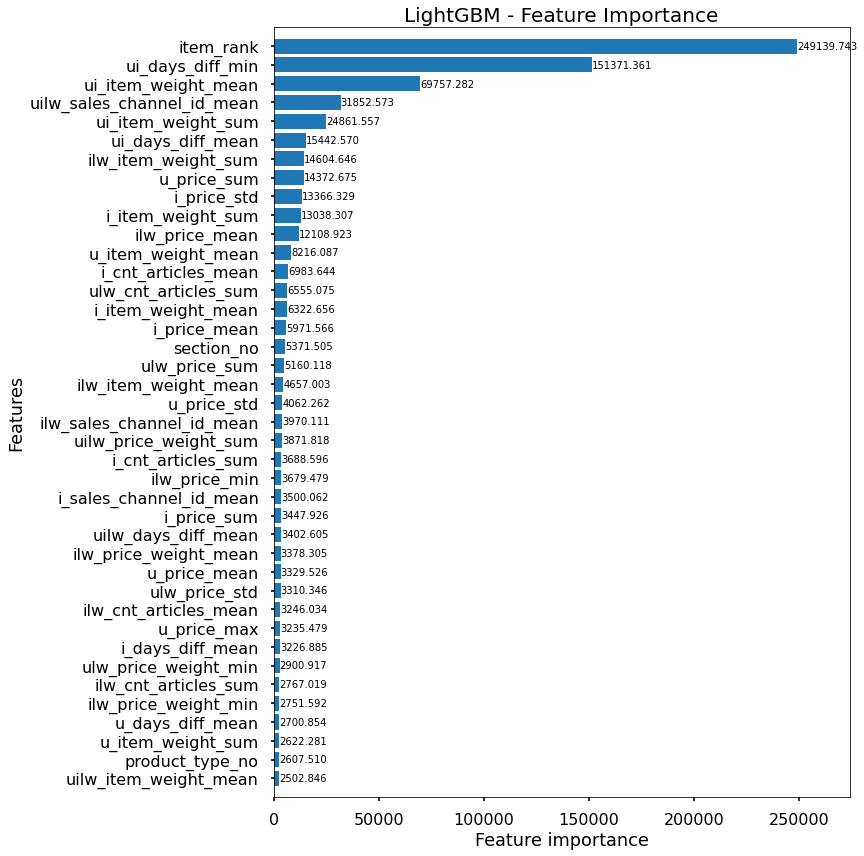

In [8]:
recommender.plot_feature_importance()
plt.show()

In [9]:
feat_import_dict = {}
for col, imp in zip(recommender.model.feature_name(), 
                    recommender.model.feature_importance(importance_type='gain')):
    feat_import_dict[col] = imp
sorted(feat_import_dict.items(), key=lambda x: x[1])

[('gender_calc', 0.0),
 ('uilw_price_sum', 48.63959884643555),
 ('index_group_no', 130.5166015625),
 ('ulw_days_diff_min', 162.53590393066406),
 ('uilw_price_weight_max', 224.55439949035645),
 ('uilw_price_weight_mean', 266.5090026855469),
 ('ulw_days_diff_mean', 388.6691999435425),
 ('u_item_weight_max', 430.10680389404297),
 ('ui_price_weight_max', 449.80659770965576),
 ('ui_price_sum', 451.9951972961426),
 ('ulw_price_weight_max', 495.1326961517334),
 ('ulw_item_weight_min', 512.0588989257812),
 ('ulw_item_weight_max', 521.0428943634033),
 ('colour_group_code', 628.1560945510864),
 ('perceived_colour_value_id', 639.2868871688843),
 ('ulw_cnt_articles_mean', 712.1688022613525),
 ('u_cnt_articles_mean', 747.5731010437012),
 ('ulw_price_min', 786.9491014480591),
 ('perceived_colour_master_id', 870.706901550293),
 ('ulw_price_weight_sum', 895.4449977874756),
 ('ulw_item_weight_sum', 899.4841957092285),
 ('ui_price_weight_sum', 928.9017000198364),
 ('product_code', 968.7918043136597),
 (

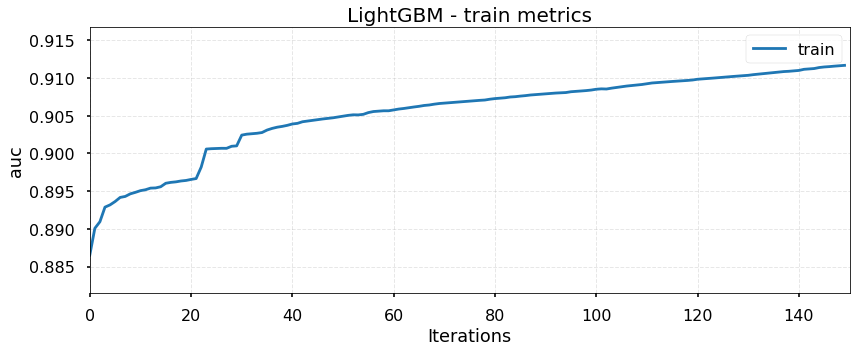

In [10]:
recommender.plot_train_metric()
plt.show()

In [11]:
# sample users for shap values calculating
# num of rows in features = num_users_shap * NUM_CANDIDATES_1LVL
num_users_shap = 5000
users = np.random.choice(features_valid['customer_id'].unique(),
                         size=num_users_shap,
                         replace=False)
# get shap object
shap_obj = recommender.calculate_shap_values(features_valid[features_valid['customer_id'].isin(users)])
logging.info('Shap values calculated')

2022-05-09 18:21:30,766 - INFO - Shap values calculated


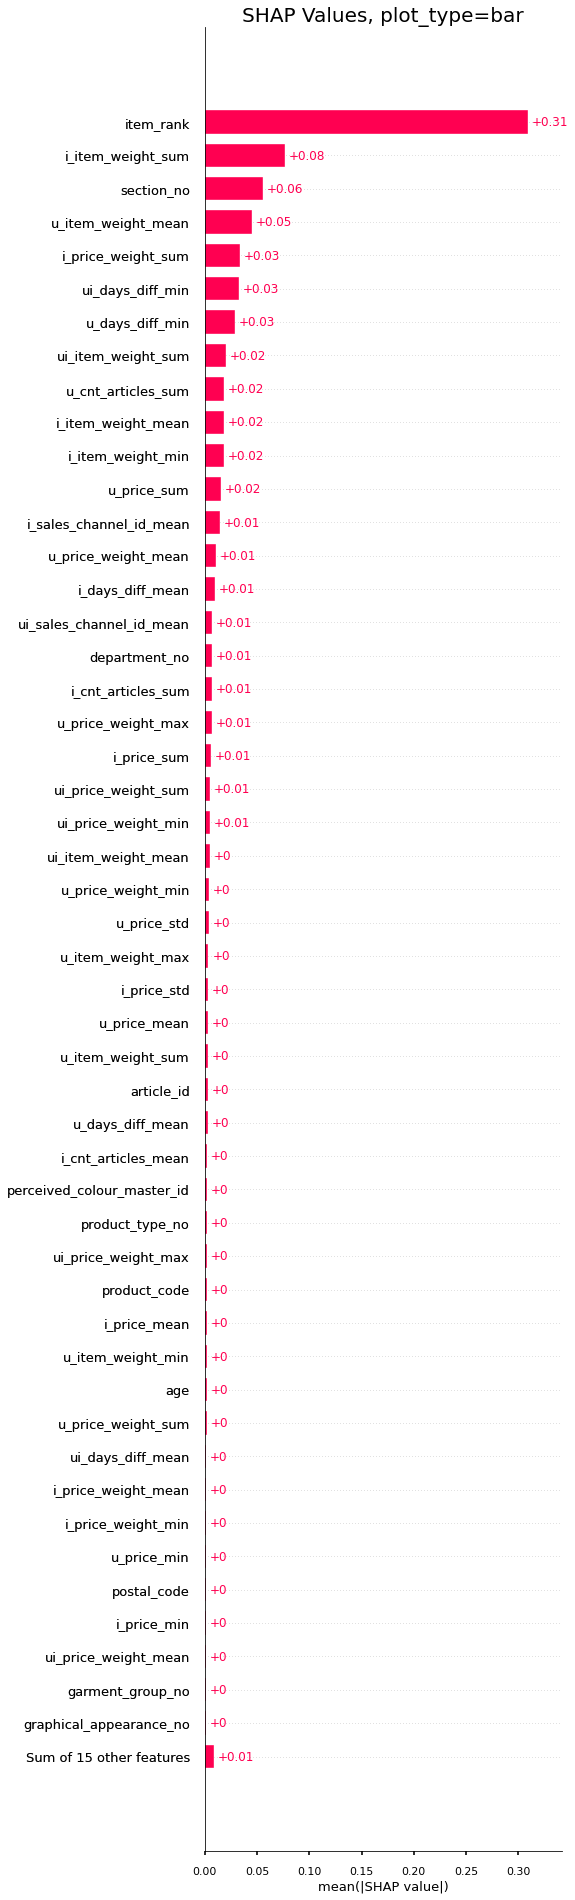

In [12]:
shap_bar_fig = recommender.plot_shap_values(shap_obj=shap_obj, plot_type='bar')
# shap_beeswarm_fig = recommender.plot_shap_values(shap_obj=shap_obj, plot_type='beeswarm')
plt.show()

## Make submission for public test

In [3]:
# load data
SUB_PATH = '../input_data/processed_data/sub_user_ind.feather'
ARTICLE_DATA_PATH = '../input_data/processed_data/articles_clean.feather'
CUSTOMER_DATA_PATH = '../input_data/processed_data/customers_clean2.feather'
TRANS_DATA_PATH = '../input_data/processed_data/trans_clean_all.feather'

trans = pd.read_feather(TRANS_DATA_PATH)

customers_data = pd.read_feather(CUSTOMER_DATA_PATH)
customers_data_feat = [
    'customer_id',
    #'FN',
    #'Active',
    'age',
    'postal_code',
    'gender_calc'
]
customers_data = customers_data[customers_data_feat]
def age_bin_util(x):
    if x < 25:
        return 18
    if 25 <= x < 35:
        return 25
    if 35 <= x < 45:
        return 35
    if 45 <= x < 55:
        return 45
    if x >= 55:
        return 55

customers_data['age_bin'] = customers_data['age'].apply(lambda x: age_bin_util(x))

article_cat_features = [
    'article_id',
    'product_code',
    'product_type_no',
    'graphical_appearance_no',
    'colour_group_code',
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_group_no',
    'section_no',
    'garment_group_no'
]

articles_data = pd.read_feather(ARTICLE_DATA_PATH)
# drop text features
articles_data = articles_data[article_cat_features]

In [4]:
RANDOM_SEED = 7
NUM_THREADS = 8
NUM_TREES = 150

model_params = {
    "model_type_1lvl": "tfidf",
    "params_1lvl": {
        "num_candidates_1lvl": 100,
        "similarity_type": "u2u",
        "user_cnt_unq_items": 0,
        "item_cnt_unq_users": 0,
        "user_item_values": "price_weight",
        "use_item_rank": True,
        "params": {
            "K": 1000,
            "num_threads": 8
        },
    },
    "model_type_2lvl": "lightgbm",
    "params_2lvl": {
        "num_trees": NUM_TREES,
        "early_stopping_rounds": 50,
        "verbose_eval": 10,
        "params": {
            "boosting": "gbdt",
            "objective": "binary",
            "metric": ["auc"],
            "seed": RANDOM_SEED,
            "learning_rate": 0.01,
            "num_leaves": 50,
            "min_data_in_leaf": 300,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.6,
            "bagging_freq": 10,
            "lambda_l2": 0.1,
            "lambda_l1": 0.1,
            "num_threads": NUM_THREADS,
            "verbosity": 2,
            "histogram_pool_size": 16384,
            "max_bin": 255,
            "save_binary": True,
            "feature_pre_filter": True
        }
    }
}

In [5]:
%%time
NUM_DAYS_FEATURES = 30 # 734 days in trans
NUM_DAYS_TARGET = 7
CUTOFF = 12
PERSONAL_GROUPBY = 'price_weight'

TARGET_VALID_START_DAY = '2020-09-23'
target_valid_start_date = datetime.strptime(TARGET_VALID_START_DAY, '%Y-%m-%d')
# get init dates
target_valid_start_date, target_valid_end_date, \
        feat_valid_start_date, feat_valid_end_date, \
        target_train_start_date, target_train_end_date, \
        feat_train_start_date, feat_train_end_date = get_dates_2lvl(
    target_valid_start_date,
    NUM_DAYS_TARGET,
    NUM_DAYS_FEATURES
)
# valid dates
logging.info('target_valid_start_date = %s', target_valid_start_date.date())
logging.info('target_valid_end_date = %s', target_valid_end_date.date())
logging.info('feat_valid_start_date = %s', feat_valid_start_date.date())
logging.info('feat_valid_end_date = %s', feat_valid_end_date.date())
# train dates
logging.info('target_train_start_date = %s', target_train_start_date.date())
logging.info('target_train_end_date = %s', target_train_end_date.date())
logging.info('feat_train_start_date = %s', feat_train_start_date.date())
logging.info('feat_train_end_date = %s', feat_train_end_date.date())

popular_articles = popular_time_decay_predict(trans, 
                                              feat_valid_start_date, 
                                              feat_valid_end_date, 
                                              CUTOFF,
                                              PERSONAL_GROUPBY)
logging.info('len(popular_articles) = %s', len(popular_articles))

preds_personal_cold = gender_age_personal_cold_start_predict(
    trans,
    feat_valid_start_date, 
    feat_valid_end_date,
    customers_data,
    articles_data,
    popular_articles,
    CUTOFF
)
logging.info('preds_personal_cold.shape = %s', preds_personal_cold.shape)

    
# load train features
features_train = get_features_2lvl(
    trans,
    feat_train_start_date, 
    feat_train_end_date,
    target_train_start_date, 
    target_train_end_date,
    model_params,
    customers_data,
    articles_data,
)
# load valid features
features_valid = get_features_2lvl(
    trans,
    feat_valid_start_date, 
    feat_valid_end_date,
    None, 
    None,
    model_params,
    customers_data,
    articles_data,
)
# define and train 2lvl model
recommender = LightGBMRecommender(
    num_trees=model_params['params_2lvl']['num_trees'],
    early_stopping_rounds=model_params['params_2lvl']['early_stopping_rounds'],
    verbose_eval=model_params['params_2lvl']['verbose_eval'],
    **model_params['params_2lvl']['params']
)
recommender.fit(features_train)
logging.info('Model %s fitted', model_params['model_type_2lvl'])

# predictions calculation
predictions_valid = recommender.predict(
    features_valid,
    num_candidates=CUTOFF,
    return_plain_df=False
)
logging.info('predictions_valid shape = %s', predictions_valid.shape)
logging.info('predictions_valid DONE')

2022-05-09 23:17:45,940 - INFO - target_valid_start_date = 2020-09-23
2022-05-09 23:17:45,940 - INFO - target_valid_end_date = 2020-09-29
2022-05-09 23:17:45,941 - INFO - feat_valid_start_date = 2020-08-23
2022-05-09 23:17:45,941 - INFO - feat_valid_end_date = 2020-09-22
2022-05-09 23:17:45,941 - INFO - target_train_start_date = 2020-09-16
2022-05-09 23:17:45,942 - INFO - target_train_end_date = 2020-09-22
2022-05-09 23:17:45,942 - INFO - feat_train_start_date = 2020-08-16
2022-05-09 23:17:45,942 - INFO - feat_train_end_date = 2020-09-15
2022-05-09 23:17:52,171 - INFO - len(popular_articles) = 12
2022-05-09 23:18:05,387 - INFO - preds_personal_cold.shape = (1371980, 2)
2022-05-09 23:18:05,388 - INFO - get_features_2lvl STARTED
2022-05-09 23:18:11,532 - INFO - Trans data collected
2022-05-09 23:18:11,776 - INFO - user_item_log.shape = (1018346, 3)
2022-05-09 23:18:11,795 - INFO - len(items_to_drop) = 0
2022-05-09 23:18:11,817 - INFO - len(users_to_drop) = 0
2022-05-09 23:18:11,832 - INF

  0%|          | 0/249511 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 25/25 [01:50<00:00,  4.42s/it]
2022-05-09 23:20:48,113 - INFO - len(preds_1lvl) = 249511
2022-05-09 23:20:48,113 - INFO - build_candidates STARTED
2022-05-09 23:20:58,738 - INFO - candidates_df shape = (24951100, 3)
2022-05-09 23:20:58,825 - INFO - build_candidates DONE
2022-05-09 23:20:59,364 - INFO - candidates_df shape = (24951100, 3)
2022-05-09 23:20:59,506 - INFO - features shape = (24951100, 3)
2022-05-09 23:21:00,527 - INFO - len(target) = 68984
2022-05-09 23:21:00,617 - INFO - target_df shape = (213728, 3)
2022-05-09 23:21:05,046 - INFO - target merged, features shape = (24951100, 4)
2022-05-09 23:21:05,487 - INFO - Mean recall 1lvl = 0.17630067558501378
2022-05-09 23:21:05,642 - INFO - Customers with zero target filtered, features shape = (1015100, 4)
2022-05-09 23:21:05,787 - INFO - customers_data_ merged, features shape = (1015100, 8)
2022-05-09 23:21:05,876 - INFO - articles_data_ merged, features shape = (1015100, 18)
2022-

  0%|          | 0/250619 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 26/26 [01:49<00:00,  4.21s/it]
2022-05-09 23:23:57,540 - INFO - len(preds_1lvl) = 250619
2022-05-09 23:23:57,541 - INFO - build_candidates STARTED
2022-05-09 23:24:08,074 - INFO - candidates_df shape = (25061900, 3)
2022-05-09 23:24:08,160 - INFO - build_candidates DONE
2022-05-09 23:24:08,686 - INFO - candidates_df shape = (25061900, 3)
2022-05-09 23:24:08,827 - INFO - features shape = (25061900, 3)
2022-05-09 23:24:10,348 - INFO - customers_data_ merged, features shape = (25061900, 7)
2022-05-09 23:24:12,594 - INFO - articles_data_ merged, features shape = (25061900, 17)
2022-05-09 23:24:18,610 - INFO - temp shape = (1054096, 10)
2022-05-09 23:24:19,209 - INFO - features_ui shape = (1020512, 11)
2022-05-09 23:24:19,500 - INFO - features_u shape = (250619, 20)
2022-05-09 23:24:19,711 - INFO - features_i shape = (29237, 15)
2022-05-09 23:24:19,819 - INFO - features_uilw shape = (213728, 10)
2022-05-09 23:24:19,878 - INFO - features_ulw 

[LightGBM] [Info] Number of positive: 14572, number of negative: 1000528
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.958842
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.180130
[LightGBM] [Debug] init for col-wise cost 0.018751 seconds, init for row-wise cost 0.159281 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17668
[LightGBM] [Info] Number of data points in the train set: 1015100, number of used features: 98
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014355 -> initscore=-4.229181
[LightGBM] [Info] Start training from score -4.229181
[LightGBM] [Debug] Re-bagging, using 609338 data to train
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
Training until validation scores don't improve for 50 rounds
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[110]	train's auc: 0.805399
[LightGBM] [Debug] Re-bagging, using 609710 data to train
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 50 and dep

2022-05-09 23:25:07,959 - INFO - Model lightgbm fitted


[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 13
[150]	train's auc: 0.811166
Did not meet early stopping. Best iteration is:
[150]	train's auc: 0.811166
Evaluated only: auc


2022-05-09 23:26:14,915 - INFO - predictions_valid shape = (250619, 2)
2022-05-09 23:26:14,916 - INFO - predictions_valid DONE


CPU times: user 13min 43s, sys: 59.1 s, total: 14min 42s
Wall time: 8min 28s


In [6]:
%%time
with open('../input_data/processed_data/ind_user.pcl', 'rb') as f:
    ind_user = pickle.load(f)

sub = pd.read_feather(SUB_PATH)
sub = sub.merge(predictions_valid, how='left', on='customer_id')
sub['prediction'] = sub['pred'].fillna('').apply(list)

# join common cold start
#sub['prediction'] = sub['prediction'].apply(lambda x: concat_items(x, popular_articles, CUTOFF))

# join personal cold start
sub = sub.merge(preds_personal_cold, how='left', on=['customer_id'])

sub['prediction'] = sub[['prediction', 'personal_cold_start']]\
                    .apply(lambda x: concat_items(x[0], x[1], CUTOFF), axis=1)

sub['customer_id'] = sub['customer_id'].apply(lambda x: ind_user[x])
sub['prediction'] = sub['prediction'].apply(lambda x: ' '.join(['0' + str(int(pred)) for pred in x]))

sub.head()

CPU times: user 13 s, sys: 143 ms, total: 13.1 s
Wall time: 13.1 s


,customer_id,pred,prediction,personal_cold_start
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[568601043, 779781015, 858856005, 851400020, 7...",0568601043 0779781015 0858856005 0851400020 07...,"[751471001, 751471043, 915529003, 928206001, 8..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,0909370001 0924243001 0863583001 0915529003 01...,"[909370001, 924243001, 863583001, 915529003, 1..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[794321007, 805000001, 794321011, 765743007, 8...",0794321007 0805000001 0794321011 0765743007 08...,"[918522001, 915526001, 751471001, 915529003, 9..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,0924243001 0918522001 0714790020 0918292001 09...,"[924243001, 918522001, 714790020, 918292001, 9..."
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,NaN,0751471001 0751471043 0915529003 0928206001 08...,"[751471001, 751471043, 915529003, 928206001, 8..."


In [7]:
sub[['customer_id', 'prediction']].to_csv('../submissions/sub_55.csv', index=False)